In [1]:
# Note that the coef. accuarcy may change slightly according each time
# the progrram is re-run due the randomness in the split.

In [ ]:
# In this notebook a random forward algorithm is designed to choose the variables which 
# give the best accuracy for the logistic regression classifier
# This notebook is a continue to Pipline_Altakroury

In [2]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer 
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel 
from pyspark.ml import Pipeline, PipelineModel 
from pyspark.mllib.evaluation import MulticlassMetrics 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, when
from pyspark.sql import SparkSession
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
spark = (SparkSession.builder
         .master('local')
         .appName('Demo full pipeline')
         .getOrCreate())

In [4]:
#--------------------------------------------------------------
# Dataset
#--------------------------------------------------------------
rawdata = spark.read.options(header='True', inferSchema='True').format("csv").load("FC-Churn.csv")

In [5]:
newdata = rawdata.where(rawdata.TotalCharges!=" ") # drop lines where TotalCharges = " "
newdata = newdata.where(newdata.gender != "NA") # drop line where gender = "NA"
newdata = newdata.where(newdata.MonthlyCharges > 0) # drop negative monthly charges
newdata = newdata.where(newdata.tenure > 0) # drop lines where tenure < 0

In [6]:
newdata = newdata.where(newdata.MonthlyCharges < 500)
newdata = newdata.where(newdata.TotalCharges < 25000)
newdata = newdata.where(newdata.tenure < 200)
newdata2 = newdata.withColumn("TotalChargesFloat", col("TotalCharges").cast("float"))
newdata_final = newdata2.withColumn("Churn", when(col("Churn") == "Yes", 1).otherwise(0))

In [7]:
genderIndexer = StringIndexer(inputCol="gender", outputCol="gender_Num")
genderEncoder = OneHotEncoder(inputCols=["gender_Num"], outputCols=["gender_Vector"])

partnerIndexer = StringIndexer(inputCol="Partner", outputCol="partner_Num")
partnerEncoder = OneHotEncoder(inputCols=["partner_Num"], outputCols=["partner_Vector"])

dependentsIndexer = StringIndexer(inputCol="Dependents", outputCol="dependents_Num")
dependentsEncoder = OneHotEncoder(inputCols=["dependents_Num"], outputCols=["dependents_Vector"])

phoneIndexer = StringIndexer(inputCol="PhoneService", outputCol="phone_Num")
phoneEncoder = OneHotEncoder(inputCols=["phone_Num"], outputCols=["phone_Vector"])

lineIndexer = StringIndexer(inputCol="MultipleLines", outputCol="line_Num")
lineEncoder = OneHotEncoder(inputCols=["line_Num"], outputCols=["line_Vector"])

netIndexer = StringIndexer(inputCol="InternetService", outputCol="net_Num")
netEncoder = OneHotEncoder(inputCols=["net_Num"], outputCols=["net_Vector"])

secIndexer = StringIndexer(inputCol="OnlineSecurity", outputCol="sec_Num")
secEncoder = OneHotEncoder(inputCols=["sec_Num"], outputCols=["sec_Vector"])

backIndexer = StringIndexer(inputCol="OnlineBackup", outputCol="back_Num")
backEncoder = OneHotEncoder(inputCols=["back_Num"], outputCols=["back_Vector"])

protectionIndexer = StringIndexer(inputCol="DeviceProtection", outputCol="protection_Num")
protectionEncoder = OneHotEncoder(inputCols=["protection_Num"], outputCols=["protection_Vector"])

techIndexer = StringIndexer(inputCol="TechSupport", outputCol="tech_Num")
techEncoder = OneHotEncoder(inputCols=["tech_Num"], outputCols=["tech_Vector"])

tvIndexer = StringIndexer(inputCol="StreamingTV", outputCol="tv_Num")
tvEncoder = OneHotEncoder(inputCols=["tv_Num"], outputCols=["tv_Vector"])

movIndexer = StringIndexer(inputCol="StreamingMovies", outputCol="mov_Num")
movEncoder = OneHotEncoder(inputCols=["mov_Num"], outputCols=["mov_Vector"])

contIndexer = StringIndexer(inputCol="Contract", outputCol="cont_Num")
contEncoder = OneHotEncoder(inputCols=["cont_Num"], outputCols=["cont_Vector"])

paperIndexer = StringIndexer(inputCol="PaperlessBilling", outputCol="paper_Num")
paperEncoder = OneHotEncoder(inputCols=["paper_Num"], outputCols=["paper_Vector"])

payIndexer = StringIndexer(inputCol="PaymentMethod", outputCol="pay_Num")
payEncoder = OneHotEncoder(inputCols=["pay_Num"], outputCols=["pay_Vector"])

In [8]:
trainDf, testDf = newdata_final.randomSplit([0.75, 0.25])

In [9]:
all_feat = ["gender_Vector", "SeniorCitizen", "partner_Vector", "dependents_Vector",
            "phone_Vector", "line_Vector", "net_Vector", "sec_Vector",
            "back_Vector", "protection_Vector", "tech_Vector", "tv_Vector",
            "mov_Vector", "cont_Vector", "paper_Vector", "pay_Vector",
             "tenure", "MonthlyCharges", "TotalChargesFloat"]


logreg = LogisticRegression(labelCol="Churn")
for i in all_feat:
    inputc = i
    dfAssembler = VectorAssembler(inputCols = [inputc] , outputCol="features")
    stage = [dfAssembler,logreg]
    if i.find("_") != -1:
        indexer = i.split("_")[0] + "Indexer"
        stage.insert(0, locals()[indexer]) # changing string to variable name
        encoder = i.split("_")[0] + "Encoder"
        stage.insert(1, locals()[encoder])
    pipeline = Pipeline(stages = stage)
    model = pipeline.fit(trainDf)
    trainingSummary = model.stages[-1].summary
    print("Training set areaUnderROC for " + i.split("_")[0] + " : " + str(trainingSummary.areaUnderROC))
    

Training set areaUnderROC for gender : 0.5105411379154857
Training set areaUnderROC for SeniorCitizen : 0.5633584581644844
Training set areaUnderROC for partner : 0.5853693730821485
Training set areaUnderROC for dependents : 0.5844421980042631
Training set areaUnderROC for phone : 0.5030840260535007
Training set areaUnderROC for line : 0.5314376676290085
Training set areaUnderROC for net : 0.690131006828137
Training set areaUnderROC for sec : 0.7048453933498864
Training set areaUnderROC for back : 0.6733565769131666
Training set areaUnderROC for protection : 0.6665175512695884
Training set areaUnderROC for tech : 0.6964932231032301
Training set areaUnderROC for tv : 0.6101383890925487
Training set areaUnderROC for mov : 0.6119123102644586
Training set areaUnderROC for cont : 0.7335699781569887
Training set areaUnderROC for paper : 0.6054785405588999
Training set areaUnderROC for pay : 0.6737793094563256
Training set areaUnderROC for tenure : 0.7341865088660372
Training set areaUnderROC

In [10]:
# from the previous results on training set 
# I considered the contract as an important variable for classifying using logistic
# As I did previous, I fix contract and add all the varaibles to see if this enhance the
# accuarcy 

In [15]:
all_feat = ["gender_Vector", "SeniorCitizen", "partner_Vector", "dependents_Vector",
            "phone_Vector", "line_Vector", "net_Vector", "sec_Vector",
            "back_Vector", "protection_Vector", "tech_Vector", "tv_Vector",
            "mov_Vector", "paper_Vector", "pay_Vector",
             "tenure", "MonthlyCharges", "TotalChargesFloat"]

#var_abb = ["gender", "partner", "dependents", "phone", "line", "net", "sec", "back",
#           "protection", "tech", "tv", "mov", "cont", "paper", "pay"]

logreg = LogisticRegression(labelCol="Churn")
for i in all_feat:
    inputc = ["cont_Vector"]
    inputc.append(i)
    dfAssembler = VectorAssembler(inputCols = inputc , outputCol="features")
    stage = [contIndexer, contEncoder, dfAssembler, logreg]
    if i.find("_") != -1:
        indexer = i.split("_")[0] + "Indexer"
        stage.insert(0, locals()[indexer]) # changing string to variable name
        encoder = i.split("_")[0] + "Encoder"
        stage.insert(1, locals()[encoder])
    pipeline = Pipeline(stages = stage)
    model = pipeline.fit(trainDf)
    trainingSummary = model.stages[-1].summary
    print("Training set areaUnderROC for contract and " + i.split("_")[0] + " : " + str(trainingSummary.areaUnderROC))

Training set areaUnderROC for gender : 0.7430393066241294
Training set areaUnderROC for SeniorCitizen : 0.7560527728571973
Training set areaUnderROC for partner : 0.7427652780348231
Training set areaUnderROC for dependents : 0.7533590305134736
Training set areaUnderROC for phone : 0.7378955559080748
Training set areaUnderROC for line : 0.7600630458539336
Training set areaUnderROC for net : 0.7999836409063268
Training set areaUnderROC for sec : 0.7874905076863872
Training set areaUnderROC for back : 0.7782352265082679
Training set areaUnderROC for protection : 0.7690029876001375
Training set areaUnderROC for tech : 0.7810338065903464
Training set areaUnderROC for tv : 0.7777495946029312
Training set areaUnderROC for mov : 0.7774158029946505
Training set areaUnderROC for paper : 0.7691825520626779
Training set areaUnderROC for pay : 0.7805665350595022
Training set areaUnderROC for tenure : 0.78016077078321
Training set areaUnderROC for MonthlyCharges : 0.7914938037408129
Training set are

In [16]:
# from the previous results on training set, in addition to contract
# I considered the InternetService as an important variable for classifying using logistic
# As I did previous, I fix contract and InternetService and add all the varaibles to see if this enhance the
# accuarcy 

In [18]:
all_feat = ["gender_Vector", "SeniorCitizen", "partner_Vector", "dependents_Vector",
            "phone_Vector", "line_Vector", "sec_Vector",
            "back_Vector", "protection_Vector", "tech_Vector", "tv_Vector",
            "mov_Vector", "paper_Vector", "pay_Vector",
             "tenure", "MonthlyCharges", "TotalChargesFloat"]


logreg = LogisticRegression(labelCol="Churn")
for i in all_feat:
    inputc = ["net_Vector", "cont_Vector" ]
    inputc.append(i)
    dfAssembler = VectorAssembler(inputCols = inputc , outputCol="features")
    stage = [netIndexer, netEncoder, contIndexer, contEncoder, dfAssembler, logreg]
    if i.find("_") != -1:
        indexer = i.split("_")[0] + "Indexer"
        stage.insert(0, locals()[indexer]) # changing string to variable name
        encoder = i.split("_")[0] + "Encoder"
        stage.insert(1, locals()[encoder])
    pipeline = Pipeline(stages = stage)
    model = pipeline.fit(trainDf)
    trainingSummary = model.stages[-1].summary
    print("Training set areaUnderROC for contract, Internet and " + i.split("_")[0] + " : " + str(trainingSummary.areaUnderROC))

Training set areaUnderROC for contract, Internet and gender : 0.8027918601850139
Training set areaUnderROC for contract, Internet and SeniorCitizen : 0.8031472252333236
Training set areaUnderROC for contract, Internet and partner : 0.8063701135699325
Training set areaUnderROC for contract, Internet and dependents : 0.8052662878554201
Training set areaUnderROC for contract, Internet and phone : 0.8020255899555532
Training set areaUnderROC for contract, Internet and line : 0.8028787965582376
Training set areaUnderROC for contract, Internet and sec : 0.8099868319394138
Training set areaUnderROC for contract, Internet and back : 0.8072171694471619
Training set areaUnderROC for contract, Internet and protection : 0.8040672635991621
Training set areaUnderROC for contract, Internet and tech : 0.8061676904411484
Training set areaUnderROC for contract, Internet and tv : 0.8031576906467846
Training set areaUnderROC for contract, Internet and mov : 0.8029893260126849
Training set areaUnderROC for

In [19]:
# from the previous results on training set, in addition to contract and Internet
# I considered the tenure as an important variable for classifying using logistic
# As I did previous, I fix contract and InternetService and add all the varaibles to see if this enhance the
# accuarcy 

In [20]:
all_feat = ["gender_Vector", "SeniorCitizen", "partner_Vector", "dependents_Vector",
            "phone_Vector", "line_Vector", "sec_Vector",
            "back_Vector", "protection_Vector", "tech_Vector", "tv_Vector",
            "mov_Vector", "paper_Vector", "pay_Vector", "MonthlyCharges", "TotalChargesFloat"]


logreg = LogisticRegression(labelCol="Churn")
for i in all_feat:
    inputc = ["net_Vector", "cont_Vector", "tenure"]
    inputc.append(i)
    dfAssembler = VectorAssembler(inputCols = inputc , outputCol="features")
    stage = [netIndexer, netEncoder, contIndexer, contEncoder, dfAssembler, logreg]
    if i.find("_") != -1:
        indexer = i.split("_")[0] + "Indexer"
        stage.insert(0, locals()[indexer]) # changing string to variable name
        encoder = i.split("_")[0] + "Encoder"
        stage.insert(1, locals()[encoder])
    pipeline = Pipeline(stages = stage)
    model = pipeline.fit(trainDf)
    trainingSummary = model.stages[-1].summary
    print("Training set areaUnderROC for contract, Internet, tenure and " + i.split("_")[0] + " : " + str(trainingSummary.areaUnderROC))

Training set areaUnderROC for contract, Internet, tenure and gender : 0.8315100563443185
Training set areaUnderROC for contract, Internet, tenure and SeniorCitizen : 0.8323056113710946
Training set areaUnderROC for contract, Internet, tenure and partner : 0.8318094222504244
Training set areaUnderROC for contract, Internet, tenure and dependents : 0.8324314717382423
Training set areaUnderROC for contract, Internet, tenure and phone : 0.8328543111628137
Training set areaUnderROC for contract, Internet, tenure and line : 0.8345678849142328
Training set areaUnderROC for contract, Internet, tenure and sec : 0.8339047999894242
Training set areaUnderROC for contract, Internet, tenure and back : 0.8317734359164181
Training set areaUnderROC for contract, Internet, tenure and protection : 0.8317946421489577
Training set areaUnderROC for contract, Internet, tenure and tech : 0.8322844969404265
Training set areaUnderROC for contract, Internet, tenure and tv : 0.8333818965238673
Training set areaUn

In [21]:
# The enhancement is slight after adding tenure so we considere only the following 
# variables for classifying according to logistic regression
# Contract, InternetServices and tenure

In [22]:
# When considering all the features (19 columns) resulted accuarcy on the training set was 0.8456002561231771
# But by the forward algorithm, only three variables were considered and approximately the same accuracy 
# was obtained 0.8319138927812887

In [1]:
# Next, the the accuarcy on the test set of the data:

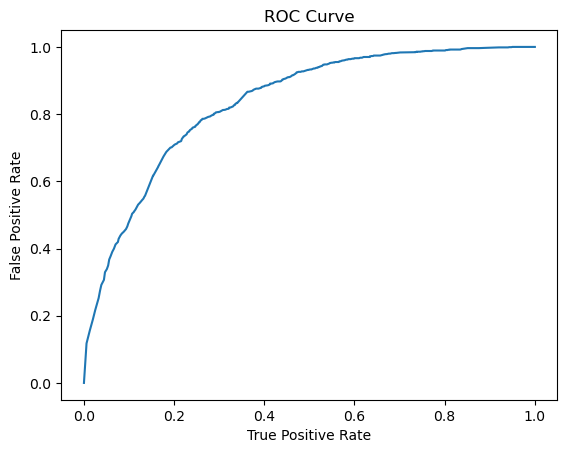

Training set areaUnderROC: 0.8341538596524493
+-----+----------+--------------------------------------------+-----------------------------------------+
|Churn|prediction|rawPrediction                               |probability                              |
+-----+----------+--------------------------------------------+-----------------------------------------+
|0    |0.0       |[1.4335969078400326,-1.4335969078400326]    |[0.8074611370810787,0.1925388629189213]  |
|0    |0.0       |[3.1255060308750426,-3.1255060308750426]    |[0.9579326686761065,0.04206733132389351] |
|0    |0.0       |[3.1255060308750426,-3.1255060308750426]    |[0.9579326686761065,0.04206733132389351] |
|0    |0.0       |[3.828201371173222,-3.828201371173222]      |[0.97871423928071,0.021285760719290003]  |
|0    |0.0       |[4.749954561532279,-4.749954561532279]      |[0.9914221281729216,0.008577871827078365]|
|0    |0.0       |[0.8367244333247992,-0.8367244333247992]    |[0.6977748956512148,0.30222510434878525] |


In [12]:
dfAssembler = VectorAssembler(inputCols=["net_Vector","cont_Vector","tenure"] , outputCol="features")
logreg = LogisticRegression(labelCol="Churn")
pipeline = Pipeline(stages=[netIndexer,
                            netEncoder,
                            contIndexer,
                            contEncoder,
                            dfAssembler,
                            logreg])                           

model = pipeline.fit(trainDf)

trainingSummary = model.stages[-1].summary
roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))



results = model.transform(testDf)

results.select("Churn","prediction","rawPrediction","probability").show(40, truncate=False)

predictionAndLabels= results.rdd.map(lambda row: (float(row.Churn), row.prediction))

# Récupération des métriques
metrics = MulticlassMetrics(predictionAndLabels)

# Matrice de confusion
print("Confusion matrix: %s" % metrics.confusionMatrix().toArray())
print("True negative: %s" % metrics.confusionMatrix().toArray()[0,0])
print("False positive: %s" % metrics.confusionMatrix().toArray()[0,1])
print("False negative: %s" % metrics.confusionMatrix().toArray()[1,0])
print("True positive: %s" % metrics.confusionMatrix().toArray()[1,1])
print("Accuracy = %s" % metrics.accuracy)

In [13]:
# The test accuarcy with three columns (0.7866295264623956) is similar to the 
# test accuarcy obtained with the 19 columns (0.8160983789826719)

In [14]:
#--------------------------------------------------------------
# BinaryClassificationEvaluator
#--------------------------------------------------------------
evaluator = BinaryClassificationEvaluator(labelCol="Churn",rawPredictionCol="rawPrediction", metricName="areaUnderPR")
						
print("Model accuracy : %s " % evaluator.evaluate(results))

Model accuracy : 0.6106178278456874 
